BloomTech Data Science

*Unit 2, Sprint 1, Module 3*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \\$100,000 and \\$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model. 

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [122]:
# imports 
import pandas as pd 
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV

In [109]:
def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',  
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    df = pd.read_csv(filepath, usecols=cols)

    # feature engineering
    # The column 'SALE DATE' becomes the DatetimeIndex.
    df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
    # The dtype for the 'BOROUGH' column is object, not int.
    df['BOROUGH'] = df['BOROUGH'].astype('object')
    # The dtype for the 'SALE PRICE' column is int, not object.
    strip_sale_price = lambda a: a.strip('$').strip().strip('-').replace(',', '')
    df['SALE PRICE'] = df['SALE PRICE'].apply(strip_sale_price).astype('int')
    # The dataset includes only one-family dwellings (BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS').
    df = df[df['BUILDING CLASS CATEGORY'] == '01 ONE FAMILY DWELLINGS']
    # The dataset includes only properties whose sale price is between \$100,000 and \$2,000,000.
    df = df[(df['SALE PRICE'] <= 2000000)&(df['SALE PRICE'] >= 100000)]
    # Create date and month columns
    df['DATE'] = df['SALE DATE'].dt.day
    df['MONTH'] = df['SALE DATE'].dt.month
    df = df.reset_index(drop=True)
    return df

filepath = DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'

**Task 1:** Use the above `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

In [110]:
df = wrangle(filepath)

In [111]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE,DATE,MONTH
0,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1325.0,1930.0,550000,2019-01-01,1,1
1,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,2001.0,1940.0,200000,2019-01-01,1,1
2,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,2043.0,1925.0,810000,2019-01-02,2,1
3,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,2680.0,1899.0,125000,2019-01-02,2,1
4,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1872.0,1940.0,620000,2019-01-02,2,1


In [74]:
df.isnull().sum()

BOROUGH                    0
NEIGHBORHOOD               0
BUILDING CLASS CATEGORY    0
GROSS SQUARE FEET          0
YEAR BUILT                 0
SALE PRICE                 0
SALE DATE                  0
dtype: int64

**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \\$100,000 and \\$2,000,000.

In [11]:
# Perform your exploratory data analysis here and
# modify the wrangle function above

# let's first look at the types of the columns
for col_name in df.columns:
  print(f'{col_name} type is {df[col_name].dtype}')

BOROUGH type is int64
NEIGHBORHOOD type is object
BUILDING CLASS CATEGORY type is object
GROSS SQUARE FEET type is float64
YEAR BUILT type is float64
SALE PRICE type is object
SALE DATE type is object


In [14]:
# describe function
df.describe(include='all')

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
count,23040.000000,23040,23040,2.303900e+04,23005.000000,23040,23040
unique,NaN,252,44,NaN,NaN,3831,120
top,NaN,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,NaN,NaN,$ - 0,01/24/2019
freq,NaN,685,5061,NaN,NaN,6909,480
mean,2.978993,NaN,NaN,3.508555e+03,1819.671724,NaN,NaN
std,1.258951,NaN,NaN,2.218610e+04,488.376571,NaN,NaN
min,1.000000,NaN,NaN,0.000000e+00,0.000000,NaN,NaN
25%,2.000000,NaN,NaN,4.940000e+02,1920.000000,NaN,NaN
50%,3.000000,NaN,NaN,1.356000e+03,1940.000000,NaN,NaN
75%,4.000000,NaN,NaN,2.280000e+03,1965.000000,NaN,NaN


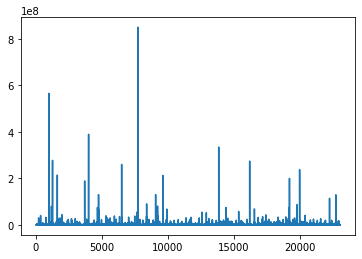

In [54]:
# Sale pirce range and disttribution
def strip_sale_price(price):
  return price.strip('$').strip().strip('-').replace(',', '')

price = df['SALE PRICE'].apply(strip_sale_price).astype('int')
plt.plot(price);

In [41]:
type(price)

pandas.core.series.Series

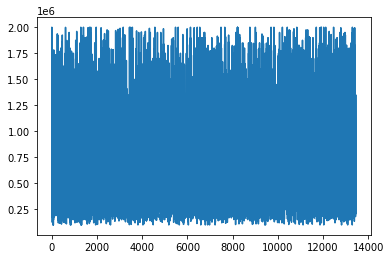

In [53]:
price2 = list(filter(lambda a: 100000 <= a <= 2000000, price))
index = range(0, len(price2))
data = pd.DataFrame(data=price2)
plt.plot(data);

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [72]:
# target = 'SALE PRICE'
# X = df.drop(target, axis=1)
# y = df[target]

In [114]:
# divide into train and test
cutoff = pd.to_datetime('2019-04-01')
train = df[df['SALE DATE'] < cutoff]
test = df[df['SALE DATE'] > cutoff]

In [115]:
# drop date column
date = 'SALE DATE'
train = train.drop(date, axis=1)
test = test.drop(date, axis=1)

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019. 
- Your test set should include data from April 2019.

In [116]:
target = 'SALE PRICE'
X_train, y_train = train.drop(target, axis=1), train[target]
X_test, y_test = test.drop(target, axis=1), test[target]

In [117]:
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((2517, 7), (2517,), (606, 7), (606,))

# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [84]:
guess = y_train.mean()
errors = y_train - guess
baseline_mae = errors.abs().mean()
print('Baseline MAE:', baseline_mae)

Baseline MAE: 216497.12357684076


# IV. Build Model 

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [120]:
ohe = ce.OneHotEncoder(use_cat_names=True)

XT_train = ohe.fit_transform(X_train)
XT_test = ohe.transform(X_test)

**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [121]:
model_lr = LinearRegression()
model_lr.fit(XT_train, y_train)

LinearRegression()

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [140]:
alphas = [0.001, 0.01, 0.05, 0.1, 0.15]
model_r = RidgeCV(alphas=alphas, normalize=True)
model_r.fit(XT_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


RidgeCV(alphas=array([0.001, 0.01 , 0.05 , 0.1  , 0.15 ]), normalize=True)

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [127]:
y_train_lr = model_lr.predict(XT_train)
y_train_r = model_r.predict(XT_train)

In [142]:
y_pred_lr = model_lr.predict(XT_test)
y_pred_r = model_r.predict(XT_test)

In [129]:
from sklearn.metrics import mean_absolute_error

training_mae_lr = mean_absolute_error(y_train_lr, y_train)
test_mae_lr = mean_absolute_error(y_pred_lr, y_test)

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

Linear Training MAE: 142698.0413190306
Linear Test MAE: 18600315642757.83


**Task 10:** Check the training and test metrics for `model_r`.

In [143]:
training_mae_r = mean_absolute_error(y_train_r, y_train)
test_mae_r = mean_absolute_error(y_pred_r, y_test)

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

Ridge Training MAE: 126333.1394012734
Ridge Test MAE: 143063.0817664843


In [144]:
model_r.alpha_

0.1

**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [145]:
# Caculate R^2 score
from sklearn.metrics import r2_score

train_r2 = r2_score(y_train, y_train_r)
test_r2 = r2_score(y_test, y_pred_r)

print(f'Train r2 score is {train_r2}')
print(f'Test r2 score is {test_r2}')

Train r2 score is 0.6187699731650452
Test r2 score is 0.450954663416682


# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

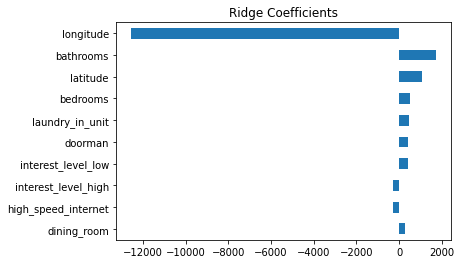

**Note:** Your figure shouldn't be identical to the one above. Your model will have different coefficients since it's been trained on different data. Only the formatting should be the same.

In [159]:
coeffs = model_r.coef_
columns = XT_test.columns
coef_data = pd.DataFrame(model_r.coef_, columns=['Model Coefs'], index=columns)
coef_data = coef_data.sort_values(by='Model Coefs')

In [162]:
coef_data = coef_data.reindex(coef_data['Model Coefs'].abs().sort_values().index)

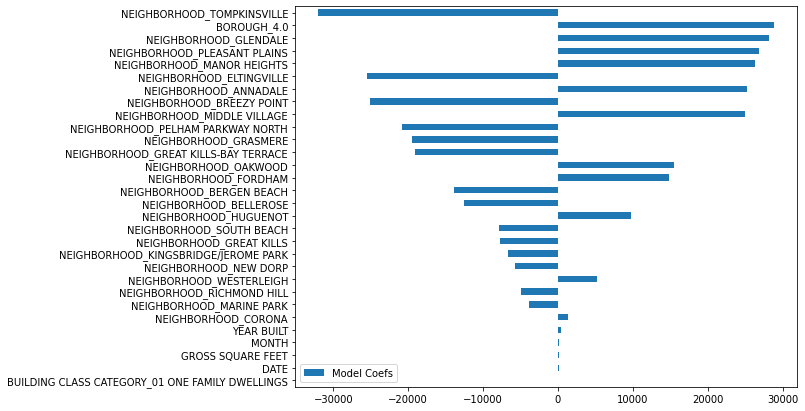

In [168]:
coef_data[:30].plot.barh(figsize=(9,7));